In [1]:
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

import all_nu_analysis as ana
import time_interval_selection as tis
import images_and_coalignment as iac

import pickle
import importlib

import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u

import sunpy.map
import glob
import region_fitting as rf
import nustar_utilities as nuutil
from astropy.io import fits

import nustar_pysolar as nustar
from astropy.coordinates import SkyCoord
from astropy import coordinates as coord
from regions import CircleSkyRegion

from scipy import ndimage


from aiapy.calibrate.util import get_correction_table, get_pointing_table
from aiapy.calibrate import register, update_pointing, degradation, estimate_error
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import Helioprojective

In [2]:
def make_ghost_plot(key, get_aia_fido=True, get_aia_local=False, aiafiles=[], show=False):
    """
    Makes a visual reference for evaluating ghost ray issues for each orbit for the chosen key.
    
    AIA files: must set one of:
        –get_aia_fido=True (fido query/download - with all the joys that entails)
        -get_aia_local=True (if relevant aia files are already in '/Users/jmdunca2/sample_aia/sample_aia/')
        -aiafiles (list of paths to one file per orbit)
    """

    file = '/Users/jmdunca2/do-dem/reference_files/all_targets_postghost_postshut.pickle'

    contourlevs = [1,2,3,5,10,20,25,50,75,99]
    colors = ['orange', 'blue', 'teal', 'indianred', 'springgreen', 'pink', 'purple', 'gold', 'yellow', 'green']

    
    with open(file, 'rb') as f:
        data = pickle.load(f)
    
    ARDict = data[key]
    
    id_dirs = ARDict['datapaths']
    obsids = ARDict['obsids']
    working_dir = ARDict['working_dir']
    #prepped_aia_dir = ARDict['prepped_aia']
    method=ARDict['method']
    
    orbit=0
    for id in id_dirs:
        sunpos = glob.glob(id+'/event_cl/*sunpos*.evt')
        count=1
        #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
        fig = plt.figure(figsize=(30,8), tight_layout = {'pad': 1})
        #axs=[ax1,ax2]
        for s in sunpos:
            with fits.open(s, ignore_missing_simple=True) as hdu:
                hdr = hdu[1].header
            time0 = nuutil.convert_nustar_time(hdr['TSTART'])
            time1 = nuutil.convert_nustar_time(hdr['TSTOP'])
            # regfile = glob.glob(working_dir+'/*.reg')[0]
            # rf.plot_file_region(s, time0, time1, regfile)
            with fits.open(s) as hdu:
                evt_data = hdu[1].data
                hdr = hdu[1].header

            cleanevt = nustar.filter.event_filter(evt_data, energy_low=2.5, energy_high=15.,
                                             no_bad_pix_filter=True, no_grade_filter=True)
        
            nustar_map = nustar.map.make_sunpy(cleanevt, hdr)
            #com = ndimage.measurements.center_of_mass(nustar_map.data)
            #com_world = nustar_map.pixel_to_world(com[1]*u.pix, com[0]*u.pix)
            #COMxy=[com_world.Tx, com_world.Ty]
            #bl = SkyCoord( *(COMxy[0].value-620, COMxy[1].value-620)*u.arcsec, frame=nustar_map.coordinate_frame)
            #tr = SkyCoord( *(COMxy[0].value+620, COMxy[1].value+620)*u.arcsec, frame=nustar_map.coordinate_frame)
            bl = SkyCoord( *(-1650, -1250)*u.arcsec, frame=nustar_map.coordinate_frame)
            tr = SkyCoord( *(1650, 1250)*u.arcsec, frame=nustar_map.coordinate_frame)
            submap = nustar_map.submap(bottom_left=bl, top_right=tr)
            ax = fig.add_subplot(1,3,count, projection=submap, aspect='auto')#, sharex=True, sharey=True)
            submap.plot(axes=ax, cmap='Greys')#
            submap.draw_contours(contourlevs, colors=colors[0:len(contourlevs)], axes=ax) #axs[count])
            submap.draw_limb(color='red', axes=ax) #axs[count])
            count+=1

        midtime = time0 + (time1-time0).to(u.s).value/2*u.s

        if get_aia_fido:
            query = Fido.search(
                a.Instrument.aia,
                a.Physobs.intensity,
                a.Wavelength(94*u.angstrom),
                a.Time(midtime-12*u.s, midtime))
            
            print(query[0])
            files = Fido.fetch(query[0], max_conn=1)
            fcount=1
            while files.errors != [] and fcount < 4:
                files = Fido.fetch(query[0], max_conn=1)
                fcount+=1
            if fcount == 4:
                print('Failed to download this AIA file 4 times:')
                print(query[0])
                return 

        elif get_aia_local:
            aia_dir = '/Users/jmdunca2/sample_aia/sample_aia/'
            files = iac.get_orbit_aiamaps(aia_dir, id_dirs, wave=94, return_files=True) 
            print(files)
            
        else:
            files=aiafiles[orbit]
            
        try:
            amap=sunpy.map.Map(files)
            #If things keep failing on the pointing table line, it may be an issue with the actual AIA map – try another time.
            ptab = get_pointing_table(amap.date - 12 * u.h, amap.date + 12 * u.h)
        except AttributeError:
            amap=sunpy.map.Map(files[0])
            #If things keep failing on the pointing table line, it may be an issue with the actual AIA map – try another time.
            ptab = get_pointing_table(amap.date - 12 * u.h, amap.date + 12 * u.h)
        
        
        try:
            m_temp = update_pointing(amap, pointing_table=ptab)
        except TypeError:
            amap.meta.pop('crpix1')
            amap.meta.pop('crpix2')
            print('CRPIX issue on ', files)
            m_temp = update_pointing(amap, pointing_table=ptab)
        
        #converts lev1 map to lev1.5 map 
        #(see: https://aiapy.readthedocs.io/en/stable/api/aiapy.calibrate.register.html?highlight=register)
        m = register(m_temp)



        #bl = SkyCoord( *(COMxy[0].value-620, COMxy[1].value-620)*u.arcsec, frame=m.coordinate_frame)
        #tr = SkyCoord( *(COMxy[0].value+620, COMxy[1].value+620)*u.arcsec, frame=m.coordinate_frame)
        #a_submap = m.submap(bottom_left=bl, top_right=tr)

        with Helioprojective.assume_spherical_screen(submap.observer_coordinate):
            a_submap = m.reproject_to(submap.wcs)

        ax = fig.add_subplot(1,3,3, projection=a_submap, aspect='auto') #, sharex=True, sharey=True)

        a_submap.plot(axes=ax, title=False)
        a_submap.draw_limb(axes=ax, color='red')

        #xlims_world = [COMxy[0].value-620, COMxy[0].value+620]*u.arcsec
        #ylims_world = [COMxy[1].value-620, COMxy[1].value+620]*u.arcsec
        #world_coords = SkyCoord(Tx=xlims_world, Ty=ylims_world, frame=a_submap.coordinate_frame)
        #pixel_coords_x, pixel_coords_y = a_submap.wcs.world_to_pixel(world_coords)
        
        #ax.set_xlim(pixel_coords_x)
        #ax.set_ylim(pixel_coords_y)
        #print(np.nanmin(a_submap.data), np.nanmean(a_submap.data), np.nanmax(a_submap.data))
        contours = a_submap.contour( np.nanmax(a_submap.data)*0.2)#*u.ct)#(np.sum(a_submap.data))*0.5 )#* u.ct)
        for contour in contours:
           ax.plot_coord(contour, color='orange')

        
        
        plt.savefig('ghost_plot_efilter2.5-15_'+obsids[orbit]+'.png')    

        if not show:
            plt.close()
            
        orbit+=1

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2018-09-07 15:26:35.000 2018-09-07 15:26:36.000    SDO ...    FULLDISK 64.64844


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2018-09-07 17:03:23.000 2018-09-07 17:03:24.000    SDO ...    FULLDISK 64.64844


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2018-09-07 18:39:59.000 2018-09-07 18:40:00.000    SDO ...    FULLDISK 64.64844


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

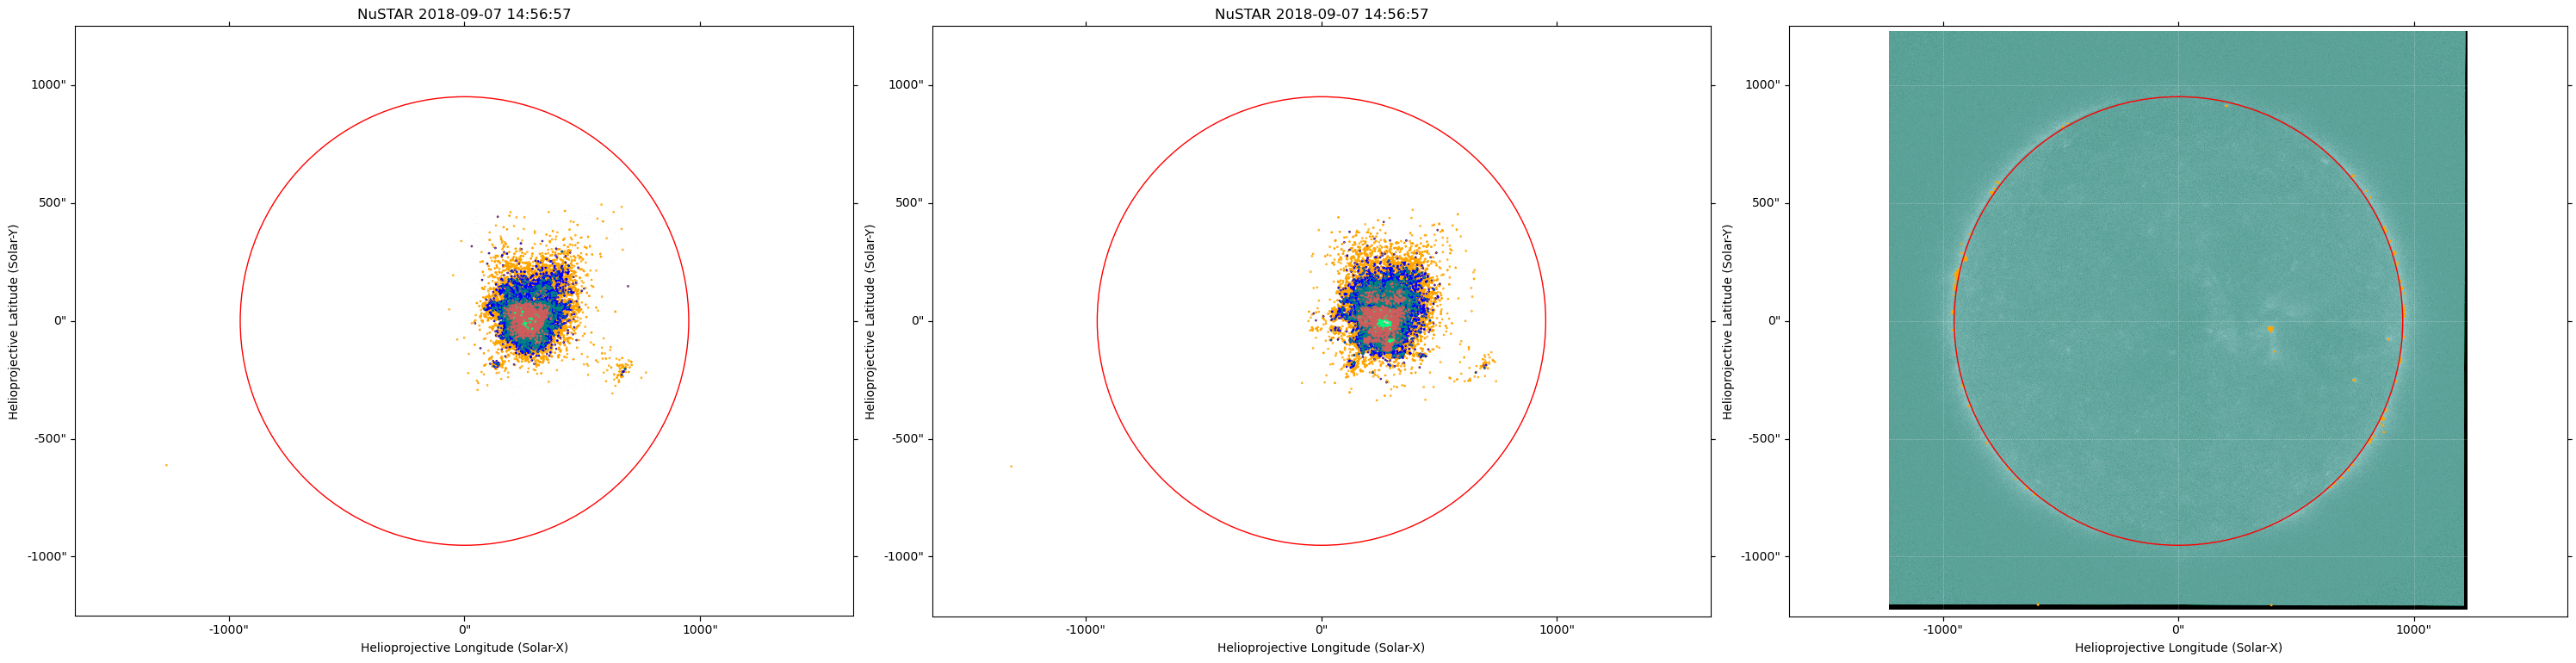

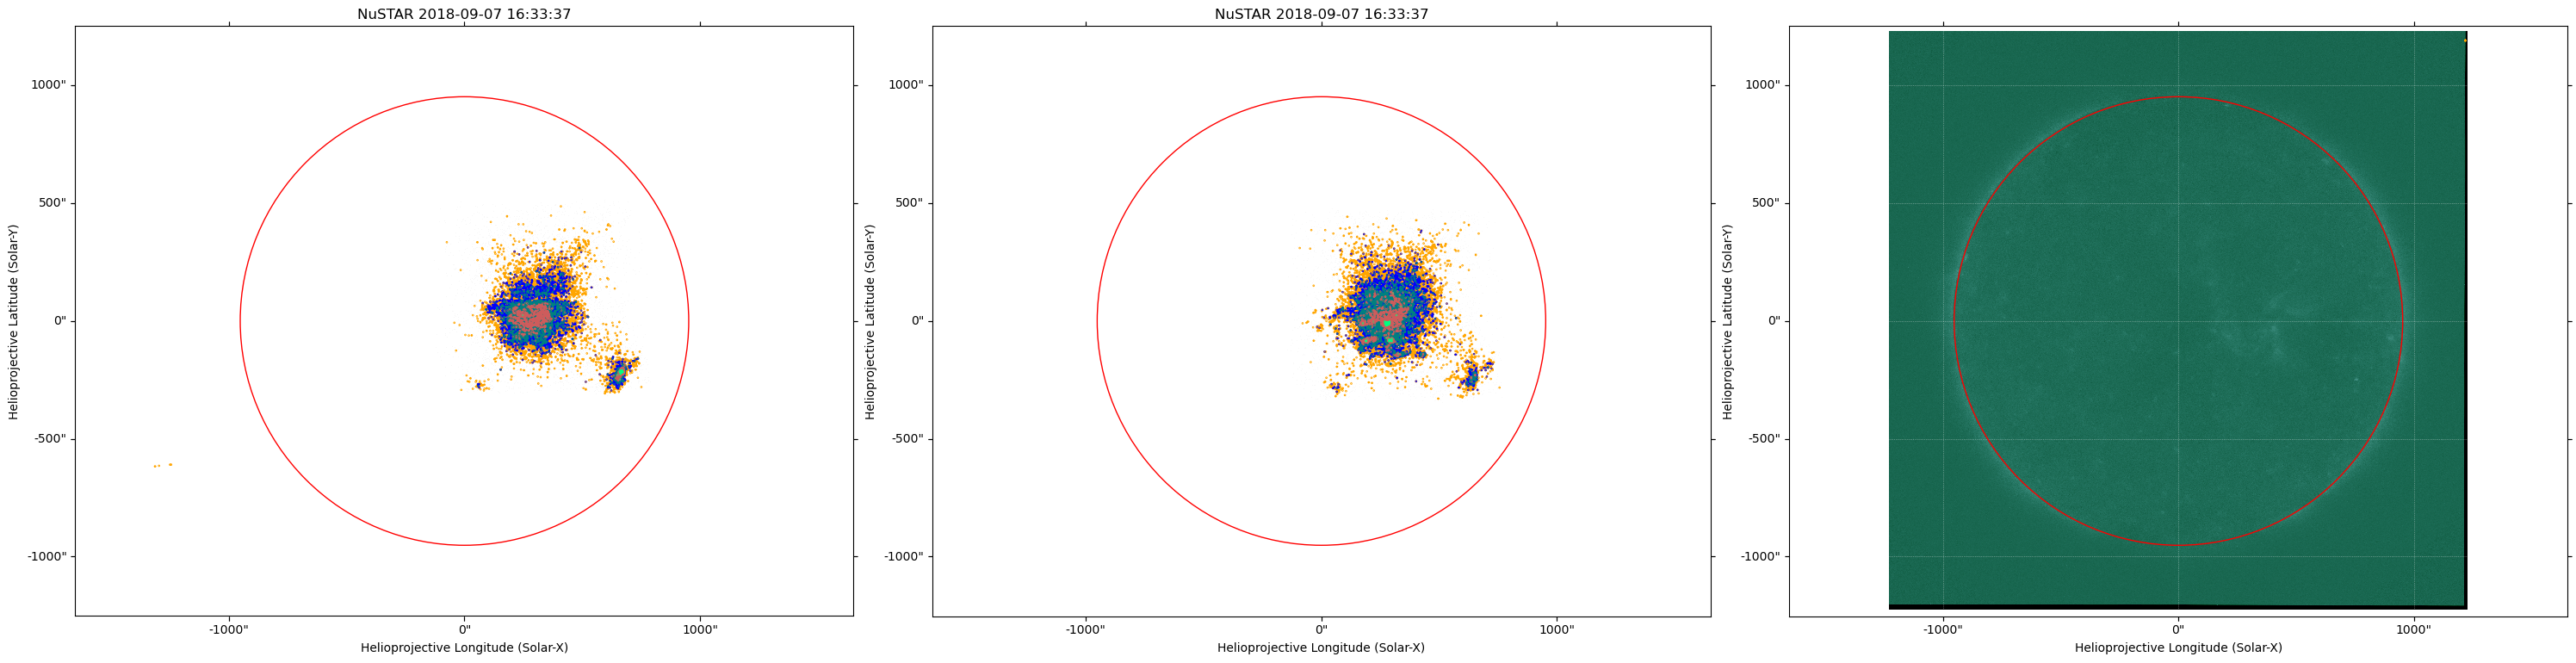

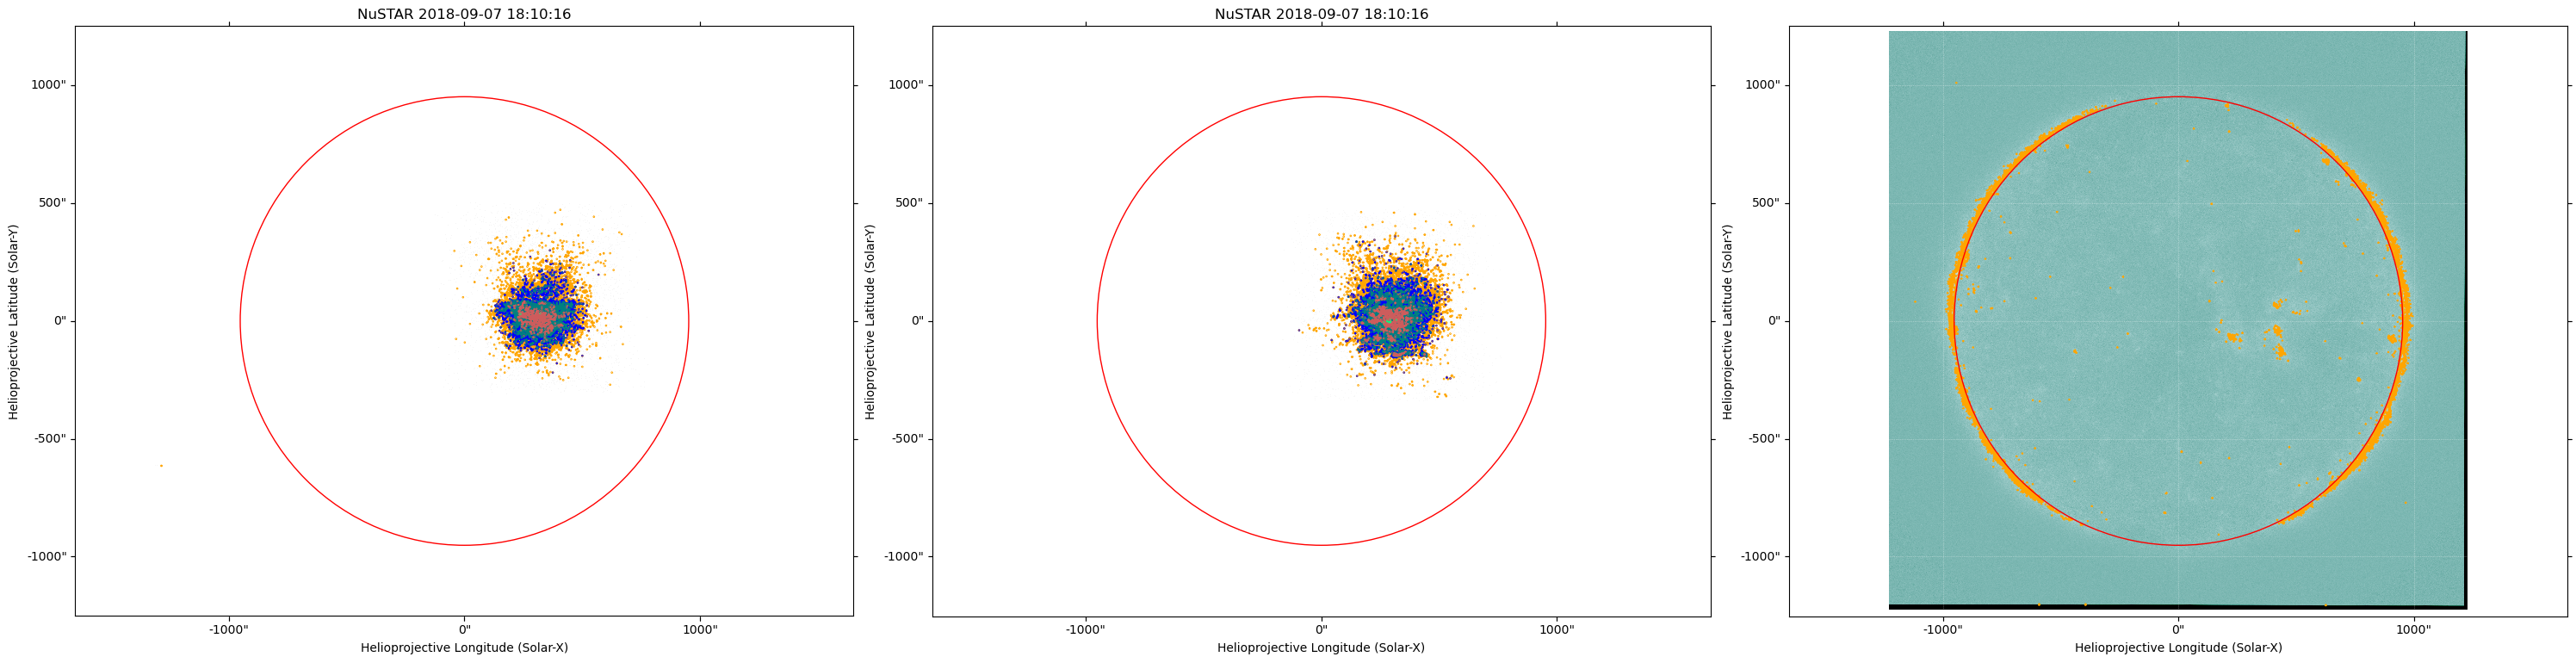

In [6]:
newnew=['07-sep-18', '11-dec-14', '14-jan-21', '01-nov-14_1', '22-nov-21_1','09-dec-22', '03-jun-22_2', '17-nov-21_1', '19-feb-16',  '22-nov-21_2', '17-nov-21_1', '17-nov-21_2', '19-nov-21', '20-nov-21', '21-nov-21', '22-nov-21', '28-dec-23', '29-dec-23','11-dec-22_1', '11-dec-22_2', '09-dec-22', '10-dec-22',
           '18-mar-23_1','18-mar-23_2']

make_ghost_plot(newnew[0], get_aia_fido=True, show=True)


In [ ]:
make_ghost_plot('27-feb-22', get_aia_fido=False, aiafiles=aias[7:8], show=True)


In [ ]:
make_ghost_plot('20-jul-21', get_aia_local=True, get_aia_fido=False)

In [ ]:
tricky = ['01-sep-15', '02-sep-15',
          '22-apr-16_2',
          '26-jul-16_1', '27-jul-16_1',
          '11-sep-17', '12-sep-17', '13-sep-17',
          '03-may-21_1', 
        '20-jul-21',
        '30-jul-21_1', '30-jul-21_2']

for key in tricky:
    make_ghost_plot(key, get_aia_local=True, get_aia_fido=False)

In [ ]:
aias = [
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_02_24t15_27_35_15z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_02_24t17_04_11_12z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_02_24t18_40_47_13z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_02_24t20_17_23_12z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_02_25t17_13_11_12z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_02_25t18_49_47_12z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_02_25t20_26_23_14z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_02_27t01_25_11_12z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_06_03t14_00_11_12z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_09_06t16_13_35_12z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_09_06t17_46_59_12z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_09_06t19_26_35_11z_image_lev1.fits',
'/Users/jmdunca2/sunpy/data/aia_lev1_94a_2022_09_06t21_03_11_12z_image_lev1.fits'
]

# print(aias[0:4])
# print('')
# print(aias[4:7])
# print('')
# print(aias[7:8])
# print('')
# print(aias[8:9])
# print('')
# print(aias[9:])
# print('')


keys = ['24-feb-22', '25-feb-22_', '27-feb-22', '03-jun-22', '06-sep-22']
make_ghost_plot(keys[0], get_aia_fido=False, aiafiles=aias[0:4])
make_ghost_plot(keys[1], get_aia_fido=False, aiafiles=aias[4:7])
make_ghost_plot(keys[2], get_aia_fido=False, aiafiles=aias[7:8])
make_ghost_plot(keys[3], get_aia_fido=False, aiafiles=aias[8:9])
make_ghost_plot(keys[4], get_aia_fido=False, aiafiles=aias[9:])

In [ ]:
with open('/Users/jmdunca2/do-dem/reference_files/all_targets_new.pickle', 'rb') as f:
    all_targets = pickle.load(f)

keyz = list(all_targets.keys())
to_do = keyz[0:-7]

for key in to_do:
    make_ghost_plot(key, get_aia_local=True, get_aia_fido=False)



In [ ]:
 make_ghost_plot(keyz[-1], get_aia_fido=True)

In [ ]:
import sunpy

sunpy.__version__

In [ ]:
# midtime = time0 + (time1-time0).to(u.s).value/2*u.s


# query = Fido.search(
#         a.Instrument.aia,
#         a.Physobs.intensity,
#         a.Wavelength(94*u.angstrom),
#         a.Time(midtime-12*u.s, midtime))
#         #a.Time(time_range[0],time_range[1]))#,
#         #a.Sample(sample_every)
#         #)
# print(query)
# files = Fido.fetch(query, max_conn=1)
# print(files)
# try:
#     amap=sunpy.map.Map(files)
#     #If things keep failing on the pointing table line, it may be an issue with the actual AIA map – try another time.
#     ptab = get_pointing_table(amap.date - 12 * u.h, amap.date + 12 * u.h)
# except AttributeError:
#     amap=sunpy.map.Map(files[0])
#     #If things keep failing on the pointing table line, it may be an issue with the actual AIA map – try another time.
#     ptab = get_pointing_table(amap.date - 12 * u.h, amap.date + 12 * u.h)


# try:
#     m_temp = update_pointing(amap, pointing_table=ptab)
# except TypeError:
#     amap.meta.pop('crpix1')
#     amap.meta.pop('crpix2')
#     print('CRPIX issue on ', files)
#     m_temp = update_pointing(amap, pointing_table=ptab)

# #converts lev1 map to lev1.5 map 
# #(see: https://aiapy.readthedocs.io/en/stable/api/aiapy.calibrate.register.html?highlight=register)
# m = register(m_temp)
